<a href="https://colab.research.google.com/github/lzrong0203/FinChatGPT202306/blob/main/WordCount.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install openai

In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
from PTTScraper import PTTScraper

In [ ]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import time


class PTTScraper:
    base_url = "https://www.ptt.cc"

    def __init__(self):
        self.base_url = PTTScraper.base_url
        self.url = self.base_url + "/bbs/Stock/index.html"

    def get_post_content(self, post_url):
        soup = PTTScraper.get_soup(self.base_url + post_url)
        content = soup.find(id='main-content').text

        # 抓取推文
        pushes = soup.find_all('div', class_='push')

        with ThreadPoolExecutor() as executor:
            push_list = list(executor.map(self.get_push, pushes))

        return content, push_list

    def get_push(self, push):
        try:
            if push.find('span', class_='push-tag') is None:
                return dict()
            push_tag = push.find('span', class_='push-tag').text.strip()
            push_userid = push.find('span', class_='push-userid').text.strip()
            push_content = push.find('span', class_='push-content').text.strip().lstrip(":")
            push_ipdatetime = push.find('span', class_='push-ipdatetime').text.strip()
            push_dict = {
                "Tag": push_tag,
                "Userid": push_userid,
                "Content": push_content,
                "Ipdatetime": push_ipdatetime
            }
        except Exception as e:
            print(e)
        return push_dict

    @staticmethod
    def get_soup(url):
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) "
                          "Chrome/58.0.3029.110 Safari/537.3", }
        response = requests.get(url, headers=headers)
        return BeautifulSoup(response.text, 'html.parser')

    def fetch_post(self, url):
        soup = PTTScraper.get_soup(self.base_url + url)

        # Extract post information
        try:
            content = soup.find(id='main-content').text
            content = content.split('※ 發信站')[0]
            if soup.find(class_='article-meta-value') is not None:
              author = soup.find(class_='article-meta-value').text
              title = soup.find_all(class_='article-meta-value')[-2].text
              date_str = soup.find_all(class_='article-meta-value')[-1].text
              date = datetime.strptime(date_str, '%a %b %d %H:%M:%S %Y')
            else:
              author = None
              title = None
              date_str = None
              date = None
        except Exception as e:
            print(self.base_url + url)
            print(e)
        # Extract comments
        pushes = soup.find_all('div', class_='push')

        with ThreadPoolExecutor() as executor:
            push_list = list(executor.map(self.get_push, pushes))
        #
        # comments = []
        # for div in soup.find_all('div', class_='push'):
        #     if div.find('span', 'push-tag') is None:
        #         continue
        #     push_tag = div.find('span', 'push-tag').text.strip()
        #     push_userid = div.find('span', 'push-userid').text.strip()
        #     push_content = div.find('span', 'push-content').text.strip()
        #     comments.append({'tag': push_tag, 'userid': push_userid, 'content': push_content})

        return {'Title': title, 'Author': author, 'Date': date, 'Content': content,
                'Link': url, 'Pushes': push_list}

    def get_data_current_page(self, soup=None, until_date=datetime.now(), *,
                              max_posts=100, links_num=0):
        reach = False
        until_date = until_date.replace(hour=0, minute=0, second=0, microsecond=0)

        if soup is None:
            soup = PTTScraper.get_soup(self.url)
        links = []
        div_element = soup.find('div', {'class': 'r-list-sep'})
        if div_element is None:
            for entry in reversed(soup.select('.r-ent')):
                try:
                    if entry.find("div", "title").a is None:
                        continue
                    # title = entry.select('.title')[0].text.strip()
                    # author = entry.select('.author')[0].text.strip()
                    date = entry.select('.date')[0].text.strip()
                    links.append(entry.select('.title a')[0]['href'])
                    # content, pushes = self.get_post_content(link)
                    # data.append({
                    #     "Title": title,
                    #     "Author": author,
                    #     "Date": date,
                    #     "Link": link,
                    #     "Content": content,
                    #     "Pushes": pushes
                    # })
                    # until_date = until_date.replace(hour=0, minute=0, second=0, microsecond=0)
                    post_date = datetime.strptime(date, '%m/%d').replace(year=until_date.year)
                    print(len(links))
                    if len(links) + links_num >= max_posts or post_date < until_date:
                        reach = True
                        break
                except Exception as e:
                    print(e)
        else:
            previous_elements = [element for element in div_element.previous_siblings if
                                 element.name == 'div' and 'r-ent' in element.get('class', [])]
            for element in reversed(previous_elements):
                # 找到標題和連結的元素
                title_link_element = element.find('a')
                if title_link_element:
                    # 取得標題和連結
                    links.append(title_link_element.get('href'))
                date_element = element.find('div', {'class': 'date'})
                if date_element:
                    # 取得發文日期
                    date = date_element.text.strip()
                post_date = datetime.strptime(date, '%m/%d').replace(year=until_date.year)
                if len(links) + links_num >= max_posts or post_date < until_date:
                    reach = True
                    break

        print(post_date)
        with ThreadPoolExecutor() as executor:
            data = list(executor.map(self.fetch_post, links))
        return data, reach, len(links)

    def get_data_until(self, until_date, *, max_posts=100):
        """
        取得到 until_date 之後的所有文章
        :param until_date:  日期
        :param max_posts: 最多抓取文章
        :return: 文章串列
        """
        data = []
        if not isinstance(until_date, datetime):
            date = datetime.strptime(until_date, '%m/%d').replace(year=datetime.now().year)
        else:
            date = until_date
        links_num = 0
        while True:
            soup = PTTScraper.get_soup(self.url)
            data_curr, date_end, num = self.get_data_current_page(soup, date,
                                                                  max_posts=max_posts, links_num=links_num)
            data.extend(data_curr)

            if date_end:
                return data
            links_num += num

            # 找到上一頁的連結
            prev_link = soup.find('a', string='‹ 上頁')['href']
            self.url = self.base_url + prev_link
        return data

    def get_data_days_before(self, delta_days, *, max_posts=100):
        """
        取得 delat_days 天之前的文章
        :param delta_days: 間隔天數
        :param max_posts: 最多回抓取幾篇PO文
        :return: 文章 list
        """
        after_date = datetime.now() - timedelta(days=delta_days)
        return self.get_data_until(after_date, max_posts=max_posts)


# 使用方式
if __name__ == "__main__":
    scraper = PTTScraper()
    begin = time.time()
    data = scraper.get_data_until("6/5")
    end = time.time()
    print(end - begin)
    df = pd.DataFrame(data)
    print(df)
    print(pd.DataFrame(df.Pushes[1]))


2023-06-05 00:00:00
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
2023-06-05 00:00:00
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
2023-06-05 00:00:00
1
2023-06-04 00:00:00
12.544748783111572
                               Title                           Author  \
0                  [情報] 8996 高力 4月自結                  DAY1986 (Prank)   
1       [新聞] 推廣金融知識 證交所發表國中版投資理財分齡教案              addy7533967 (火爆刺香腸)   
2   [情報] 5864 致和證 5月自結 0.91 累計 3.310                     aspoercig ()   
3        Re: [請益] 現在是不是出清0050停扣的好時機？            frankfurt (frankfurt)   
4               [情報] 2515 中工 處分臺企銀股票                      q1a1 (一問一答)   
5                  [情報] 6446藥華藥 5月營收                curry1012 (三餐喝醬油)   
6                  [情報] 3213 茂訊 5月營收                     max220 (MaX)   
7                   [情報] 5864 致和證 5月               DDDDRR (QQ到線鐵定一大堆)   
8          Re: [標的] 9945 潤泰新 主力籌碼吸爆多                    potabaw (...)   
9         [新聞] 大立光5月營收探2月以來新低點 6月動能可                  lspss93009 (歐文)   
10 

In [ ]:
csv_file = "stock_20230605.csv"
path = f"/content/drive/MyDrive/{csv_file}" 
df.to_csv(path, index_label=False)

In [ ]:
!pip install -U ckiptagger[tf,gdown]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

In [ ]:
# data_utils.download_data_gdown("./")
data_utils.download_data_url("./")

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
ws = WS("./data", disable_cuda=False)
pos = POS("./data", disable_cuda=False)
ner = NER("./data", disable_cuda=False)

/usr/local/lib/python3.10/dist-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/usr/local/lib/python3.10/dist-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/usr/local/lib/python3.10/dist-packages/ckiptagger/model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


In [ ]:
sentence_list = list(df.Content)

In [ ]:
word_sentence_list = ws(
    sentence_list,
    # sentence_segmentation = True, # To consider delimiters
    # segment_delimiter_set = {",", "。", ":", "?", "!", ";"}), # This is the defualt set of delimiters
    # recommend_dictionary = dictionary1, # words in this dictionary are encouraged
    # coerce_dictionary = dictionary2, # words in this dictionary are forced
)

pos_sentence_list = pos(word_sentence_list)

entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

In [ ]:
# def print_word_pos_sentence(word_sentence, pos_sentence):
#     assert len(word_sentence) == len(pos_sentence)
#     for word, pos in zip(word_sentence, pos_sentence):
#         print(f"{word}({pos})", end="\u3000")
#     print()
#     return
    
# for i, sentence in enumerate(sentence_list):
#     print()
#     print(f"'{sentence}'")
#     print_word_pos_sentence(word_sentence_list[i],  pos_sentence_list[i])
#     for entity in sorted(entity_sentence_list[i]):
#         print(entity)

In [ ]:
entity_sentence_list

[{(39, 41, 'DATE', '4月'),
  (85, 87, 'DATE', '4月'),
  (151, 155, 'CARDINAL', '8996'),
  (164, 167, 'DATE', '4月份'),
  (171, 177, 'MONEY', '6400萬元')},
 {(2, 6, 'PERSON', 'addy'),
  (224, 226, 'DATE', '今天'),
  (252, 254, 'DATE', '6日'),
  (411, 418, 'DATE', '2022年2月'),
  (669, 671, 'DATE', '6日'),
  (675, 678, 'ORG', '證交所'),
  (681, 684, 'PERSON', '簡立忠'),
  (687, 693, 'ORG', '金管會證期局'),
  (701, 711, 'ORG', '北市教育局國教輔導團'),
  (715, 718, 'PERSON', '李朝盛'),
  (721, 725, 'ORG', '古亭國中'),
  (727, 730, 'PERSON', '林泰安'),
  (731, 735, 'ORG', '南門國中'),
  (742, 746, 'ORG', '龍門國中'),
  (748, 751, 'PERSON', '鍾芷芬'),
  (920, 922, 'ORDINAL', '第一'),
  (942, 945, 'ORG', 'TSM')},
 {(2, 12, 'PERSON', 'aspoercig '),
  (37, 39, 'DATE', '5月'),
  (93, 100, 'DATE', '112年5月份'),
  (203, 209, 'ORG', '致和證券股份'),
  (267, 274, 'DATE', '112年5月份'),
  (282, 285, 'DATE', '五月份'),
  (290, 293, 'MONEY', '242'),
  (294, 299, 'MONEY', '012仟元'),
  (303, 306, 'DATE', '五月份'),
  (311, 320, 'MONEY', '247,765仟元'),
  (322, 323, 'CARDINAL', '3'

In [ ]:
import json

ckip_file_ws = "ckip_ws.txt"
ckip_file_pos = "ckip_pos.txt"
ckip_file_en = "ckip_en.txt"

path = f"/content/drive/MyDrive/{ckip_file_ws}" 
with open(path, 'w') as f:
  json.dump(word_sentence_list, f)

path = f"/content/drive/MyDrive/{ckip_file_pos}" 
with open(path, 'w') as f:
  json.dump(pos_sentence_list, f)

path = f"/content/drive/MyDrive/{ckip_file_en}" 
with open(path, 'w') as f:
  json.dump(entity_sentence_list, f)

TypeError: ignored

In [ ]:
import pandas as pd

count_list = []
# count_dict = {}
for e in entity_sentence_list:
    for i in e:
#         count_dict[i[3]] = count_dict.get(i[3], 0) + 1
#         df = pd.concat([df, pd.DataFrame(i[3])])
        if i[2] != 'DATE':
          count_list.append(i[3])

In [ ]:
entity_sentence_list

[{(39, 41, 'DATE', '4月'),
  (85, 87, 'DATE', '4月'),
  (151, 155, 'CARDINAL', '8996'),
  (164, 167, 'DATE', '4月份'),
  (171, 177, 'MONEY', '6400萬元')},
 {(2, 6, 'PERSON', 'addy'),
  (224, 226, 'DATE', '今天'),
  (252, 254, 'DATE', '6日'),
  (411, 418, 'DATE', '2022年2月'),
  (669, 671, 'DATE', '6日'),
  (675, 678, 'ORG', '證交所'),
  (681, 684, 'PERSON', '簡立忠'),
  (687, 693, 'ORG', '金管會證期局'),
  (701, 711, 'ORG', '北市教育局國教輔導團'),
  (715, 718, 'PERSON', '李朝盛'),
  (721, 725, 'ORG', '古亭國中'),
  (727, 730, 'PERSON', '林泰安'),
  (731, 735, 'ORG', '南門國中'),
  (742, 746, 'ORG', '龍門國中'),
  (748, 751, 'PERSON', '鍾芷芬'),
  (920, 922, 'ORDINAL', '第一'),
  (942, 945, 'ORG', 'TSM')},
 {(2, 12, 'PERSON', 'aspoercig '),
  (37, 39, 'DATE', '5月'),
  (93, 100, 'DATE', '112年5月份'),
  (203, 209, 'ORG', '致和證券股份'),
  (267, 274, 'DATE', '112年5月份'),
  (282, 285, 'DATE', '五月份'),
  (290, 293, 'MONEY', '242'),
  (294, 299, 'MONEY', '012仟元'),
  (303, 306, 'DATE', '五月份'),
  (311, 320, 'MONEY', '247,765仟元'),
  (322, 323, 'CARDINAL', '3'

In [ ]:
df = pd.DataFrame(count_list, columns=["entity"])
text = df.entity.value_counts()
text.head(30)

吳東進      20
台積電      18
美國       16
吳東亮      11
一萬       10
新光金      10
台灣       10
長榮        9
三         9
老蘇        9
兩         9
第一        8
哲哲        8
八         7
5         7
10%       7
30        7
560       6
一         6
晚上        5
郭泰        5
1.49%     5
琳達        5
早上        5
日本        5
第二        5
3         5
新光集團      5
第三        5
中鋼        5
Name: entity, dtype: int64

--2023-06-05 11:34:44--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 142.250.125.128, 2607:f8b0:4001:c2f::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121247366 (116M) [application/zip]
Saving to: ‘NotoSansCJKtc-hinted.zip’

NotoSansCJKtc-hinte 100%[===================>] 115.63M   166MB/s    in 0.7s    

2023-06-05 11:34:45 (166 MB/s) - ‘NotoSansCJKtc-hinted.zip’ saved [121247366/121247366]

Archive:  NotoSansCJKtc-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSansCJKtc-Black.otf  
  inflating: NotoSansCJKtc-Bold.otf  
  inflating: NotoSansCJKtc-DemiLight.otf  
  inflating: NotoSansCJKtc-Light.otf  
  inflating: NotoSansCJKtc-Medium.otf  
  inflating: NotoSansCJKtc-Regular.otf  
  inflating: NotoSansCJKtc-Th

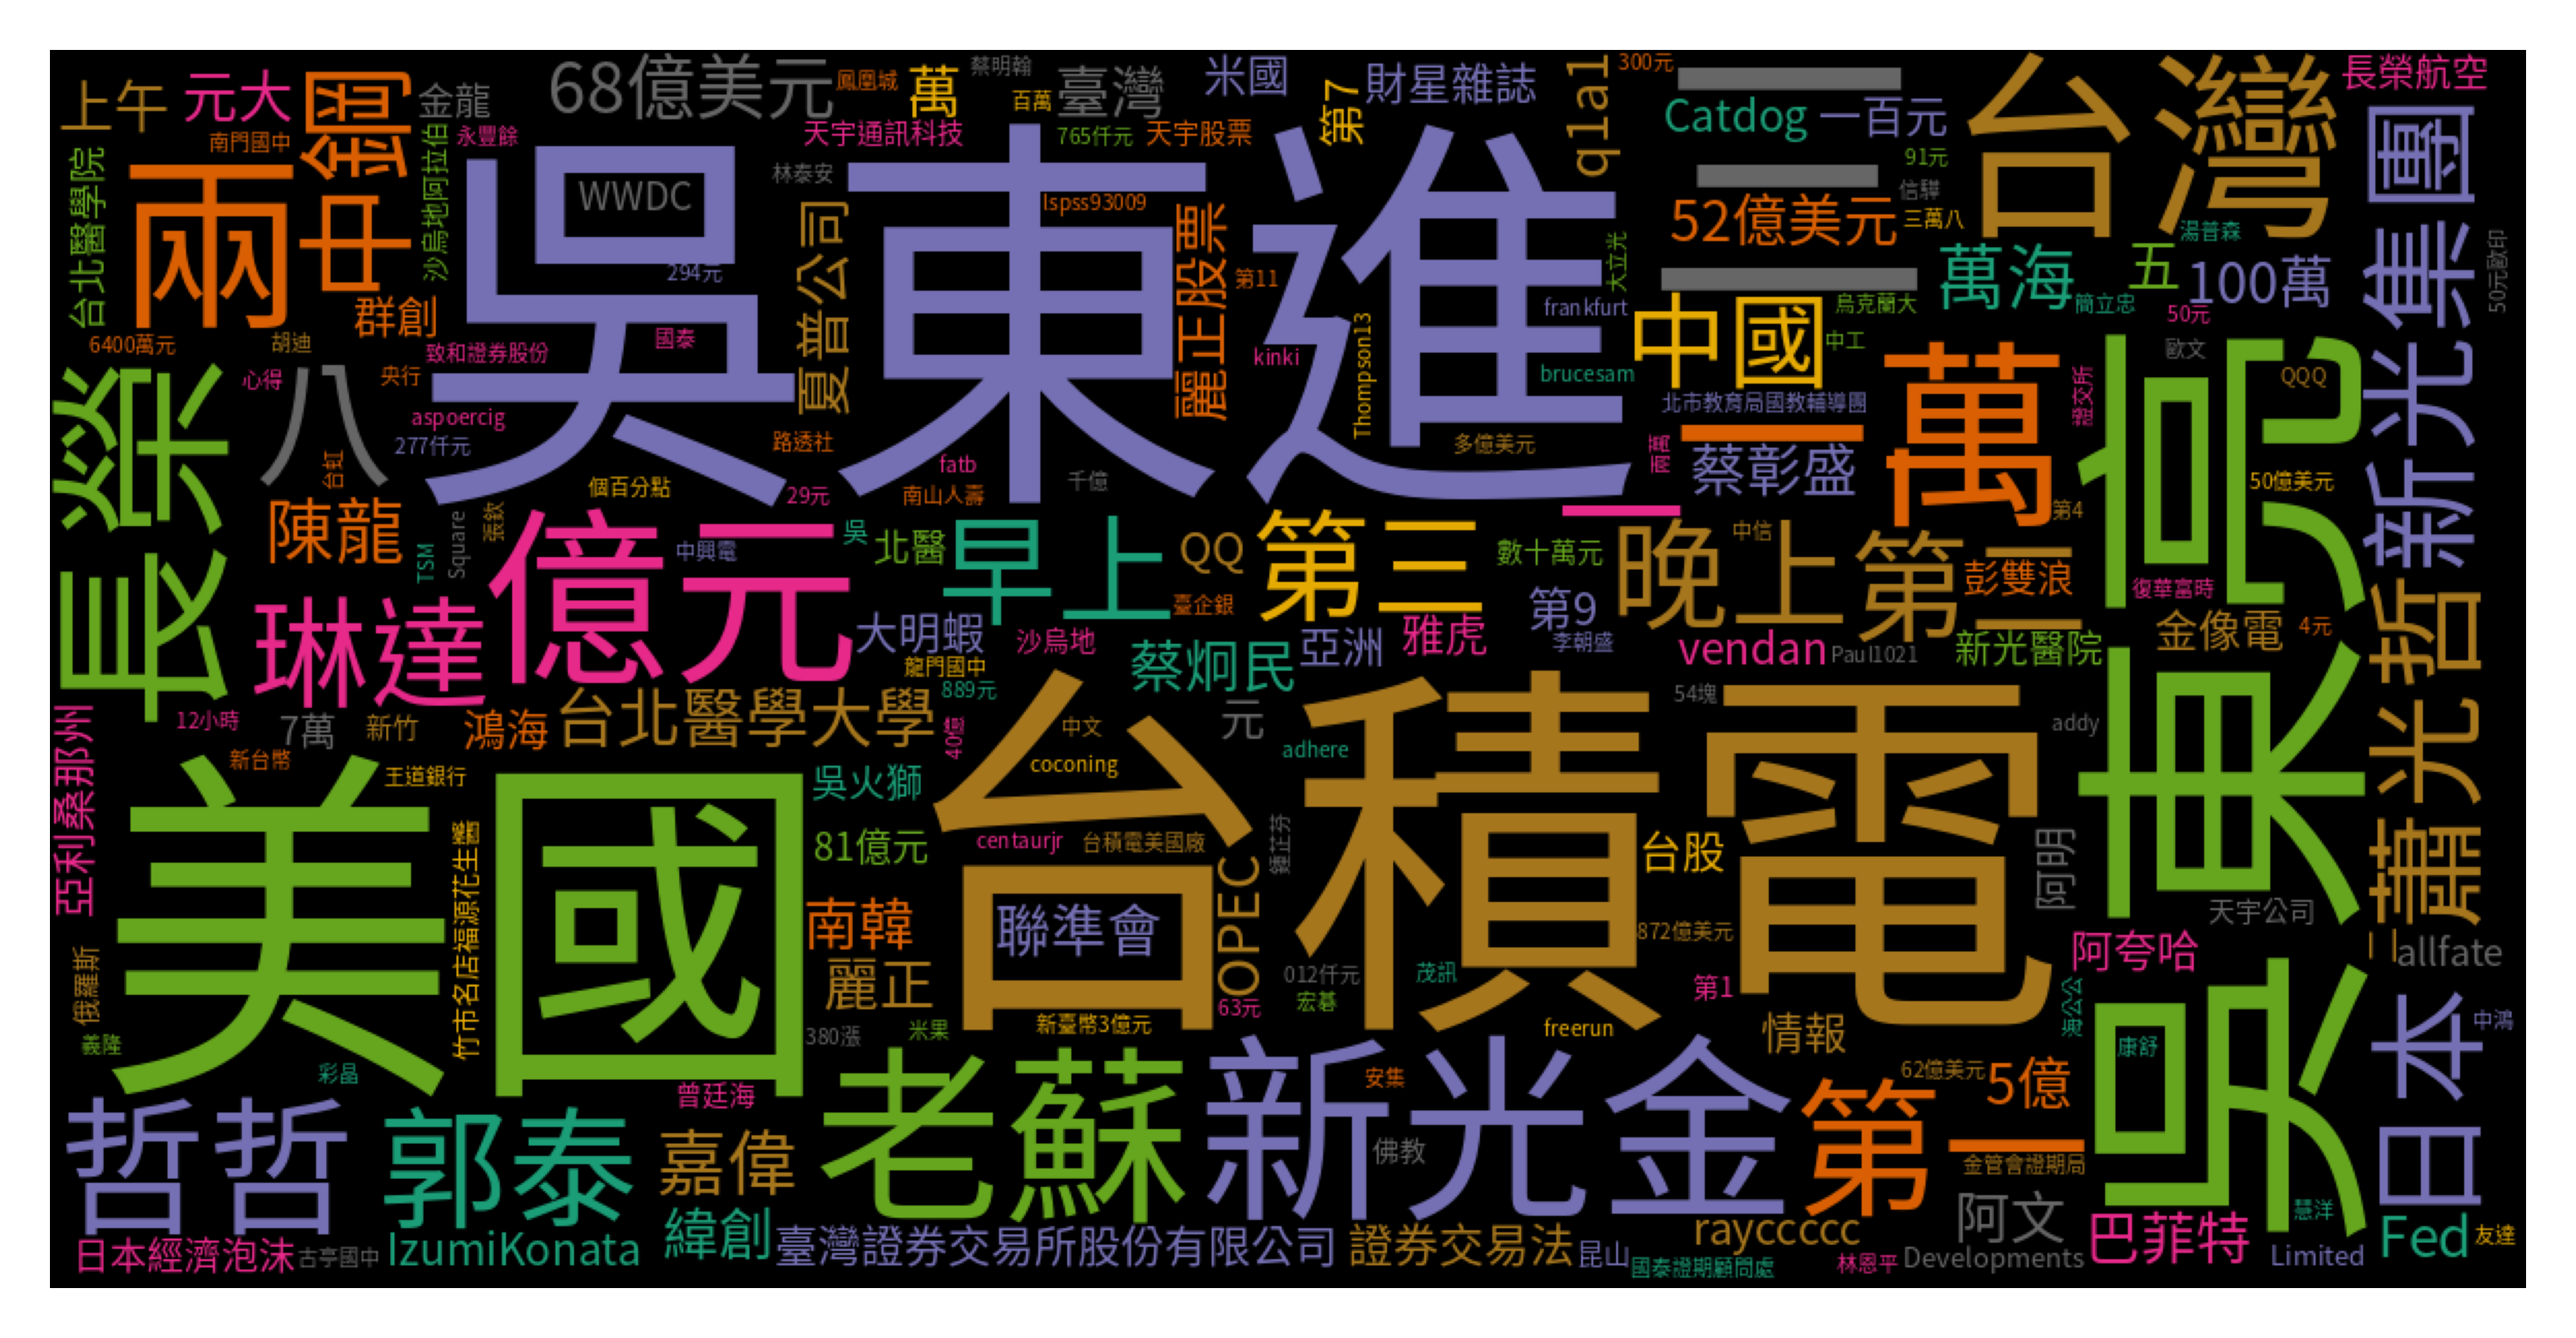

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

!wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip"
!unzip "NotoSansCJKtc-hinted.zip"

text = " ".join(review for review in count_list)
# back_color = imageio.imread("./taiwan.png")
wordcloud = WordCloud(width=1200, height=600, max_font_size=200, max_words=200, background_color="black", 
                      font_path='NotoSansCJKtc-Regular.otf', colormap="Dark2").generate(text)
plt.figure(dpi=600)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()  

In [ ]:
# 中斷後重新讀取結果
import itertools


ckip_file_ws = "ckip_ws.txt"
ckip_file_pos = "ckip_pos.txt"
ckip_file_en = "ckip_en.txt"
word_sentence_list = []
path = f"/content/drive/MyDrive/{ckip_file_ws}" 
with open(path, 'r') as f:
  for line in f.readlines():
    line = json.loads(line)

# pos_sentence_list = []
# path = f"/content/drive/MyDrive/{ckip_file_pos}" 
# with open(path, 'r') as f:
#   for line in f.readlines():
#     line = list(line)
#     pos_sentence_list = list(itertools.chain(pos_sentence_list, line))


# entity_sentence_list = []
# path = f"/content/drive/MyDrive/{ckip_file_en}" 
# with open(path, 'r') as f:
#   for line in f.readlines():
#     line = list(line)
#     entity_sentence_list = list(itertools.chain(entity_sentence_list, line))
# # path = f"/content/drive/MyDrive/{ckip_file_en}" 
# # with open(path, 'a') as f:
# #   for en in entity_sentence_list:
# #     f.write("%s\n" % en)

In [ ]:
# def print_word_pos_sentence(word_sentence, pos_sentence):
#     assert len(word_sentence) == len(pos_sentence)
#     for word, pos in zip(word_sentence, pos_sentence):
#         print(f"{word}({pos})", end="\u3000")
#     print()
#     return
    
# for i, sentence in enumerate(sentence_list):
#     print()
#     print(f"'{sentence}'")
#     print_word_pos_sentence(word_sentence_list[i],  pos_sentence_list[i])
#     for entity in sorted(entity_sentence_list[i]):
#         print(entity)

In [ ]:
import json
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
ckip_file_ws = "ckip_ws.txt"
ckip_file_pos = "ckip_pos.txt"
ckip_file_en = "ckip_en.txt"
path = f"/content/drive/MyDrive/{ckip_file_ws}" 
with open(path, 'r') as f:
  word_sentence_list = json.load(f)
word_sentence_list

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[1, 2, 3, 4]

In [ ]:
a = 0
ans = "B" if a <= 10 else "L"
print(ans)

B
